# Skin Cancer Detector Model Design Pipeline

Using the Data Set HAM10000 available on Kaggle

https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T

[1] Noel Codella, Veronica Rotemberg, Philipp Tschandl, M. Emre Celebi, Stephen Dusza, David Gutman, Brian Helba, Aadi Kalloo, Konstantinos Liopyris, Michael Marchetti, Harald Kittler, Allan Halpern: “Skin Lesion Analysis Toward Melanoma Detection 2018: A Challenge Hosted by the International Skin Imaging Collaboration (ISIC)”, 2018; https://arxiv.org/abs/1902.03368
[2] Tschandl, P., Rosendahl, C. & Kittler, H. The HAM10000 dataset, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. Sci. Data 5, 180161 doi:10.1038/sdata.2018.161 (2018).

## 1. Data loading

### 1.1 Load metadata as pandas dataframe


In [1]:
import pandas as pd

metadata = pd.read_csv("skin_conditions_dataset/HAM10000_metadata.csv")

metadata.drop(["lesion_id", "dx_type"], axis=1, inplace=True)
metadata

,image_id,dx,age,sex,localization
0,ISIC_0027419,bkl,80.0,male,scalp
1,ISIC_0025030,bkl,80.0,male,scalp
2,ISIC_0026769,bkl,80.0,male,scalp
3,ISIC_0025661,bkl,80.0,male,scalp
4,ISIC_0031633,bkl,75.0,male,ear
...,...,...,...,...,...
10010,ISIC_0033084,akiec,40.0,male,abdomen
10011,ISIC_0033550,akiec,40.0,male,abdomen
10012,ISIC_0033536,akiec,40.0,male,abdomen
10013,ISIC_0032854,akiec,80.0,male,face


### 1.2 Load images as pyTorch tensor 

In [2]:
from src.DataLoader import DataLoader

loader = DataLoader("skin_conditions_dataset/HAM10000_images_part_1", metadata, "image_id", "dx", augmentation=True)

torch.Size([10, 3, 450, 450])


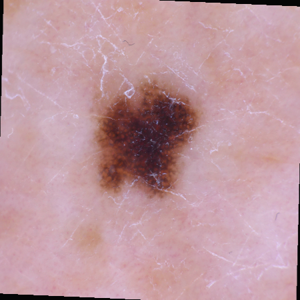

Label: nv


In [18]:
from torchvision.transforms import ToPILImage

loader.load_images(0.001)
X_images = loader.get_X()

# Check if images are being loaded correctly
print(X_images.shape)
to_pil = ToPILImage()
image = to_pil(X_images[0])

# Now you can display or save the image
display(image.resize((300, 300)))
label_image = loader.get_y()[0].item()
print("Label: "+ loader.get_encoder().inverse_transform([label_image])[0])
